In [1]:
import os
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf; print('Tensorflow version:',tf.__version__)
from tensorflow.keras import layers
from tensorflow.keras import regularizers
import sklearn
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import balanced_accuracy_score, accuracy_score

Tensorflow version: 2.8.1


In [2]:
print('Available devices:', tf.config.list_physical_devices())

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=2*1024)]
    )

Available devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2022-11-02 20:13:32.871809: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-02 20:13:32.915805: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-02 20:13:32.916054: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [3]:
DIRECTORY = 'dataset'
IMAGE_SIZE = (224, 224)
IMAGE_SHAPE = IMAGE_SIZE + (3,)
BATCH_SIZE = 16
COLOR_MODE='grayscale'

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
      directory=DIRECTORY
    , image_size=IMAGE_SIZE
    , batch_size=BATCH_SIZE    
    , color_mode=COLOR_MODE
    , validation_split=0.1
    , subset="training"
    , seed=123
)

validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
      directory=DIRECTORY
    , image_size=IMAGE_SIZE
    , batch_size=BATCH_SIZE
    , color_mode=COLOR_MODE
    , validation_split=0.1
    , subset="validation"
    , seed=123
)

Found 5481 files belonging to 8 classes.
Using 4933 files for training.


2022-11-02 20:13:33.131412: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-02 20:13:33.131921: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-02 20:13:33.132319: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-02 20:13:33.132580: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so retur

Found 5481 files belonging to 8 classes.
Using 548 files for validation.


In [4]:
qtyLabels = [0]*8
Images = {}
for images, labels in train_dataset:
    for image, label in zip(images, labels):
        label = int(label)
        qtyLabels[label] += 1  
        if ( label in Images ):
            if  ( len(Images[label]) < 20 ):
                Images[label].append(image)
        else:
            Images[label] = []
            Images[label].append(image)
class_names = train_dataset.class_names
print(' '.join( ['{:<12}'.format(el) for el in class_names] ))
print(' '.join( ['{:<12}'.format(el) for el in qtyLabels] ))

anger        contempt     disgust      fear         happiness    neutrality   sadness      surprise    
793          191          389          518          1237         446          656          703         


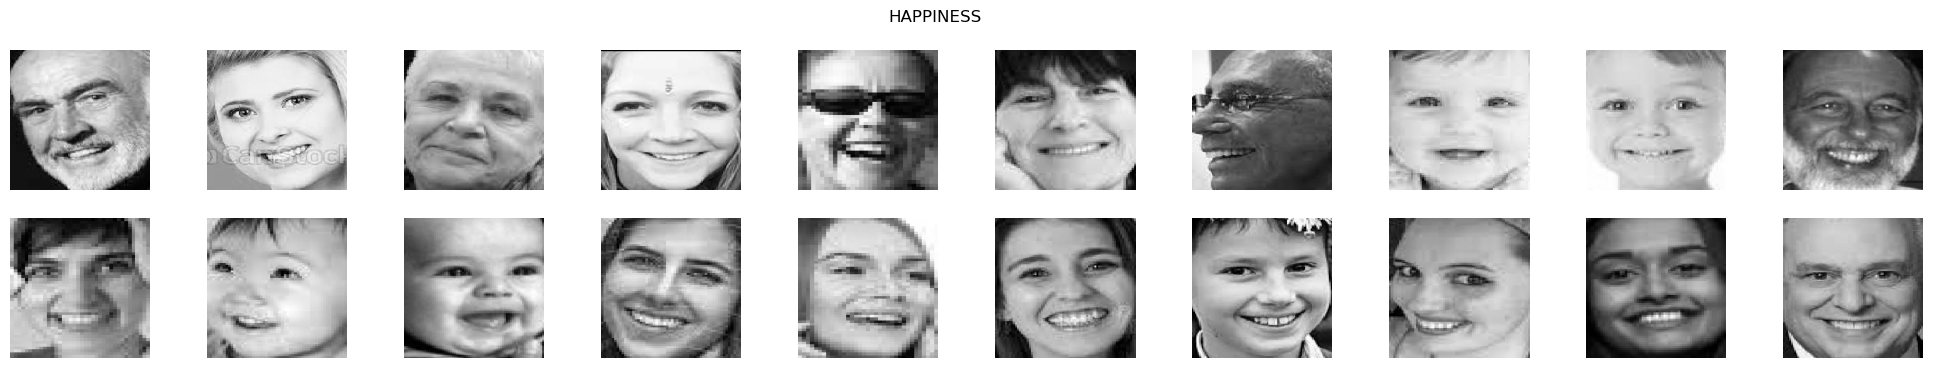

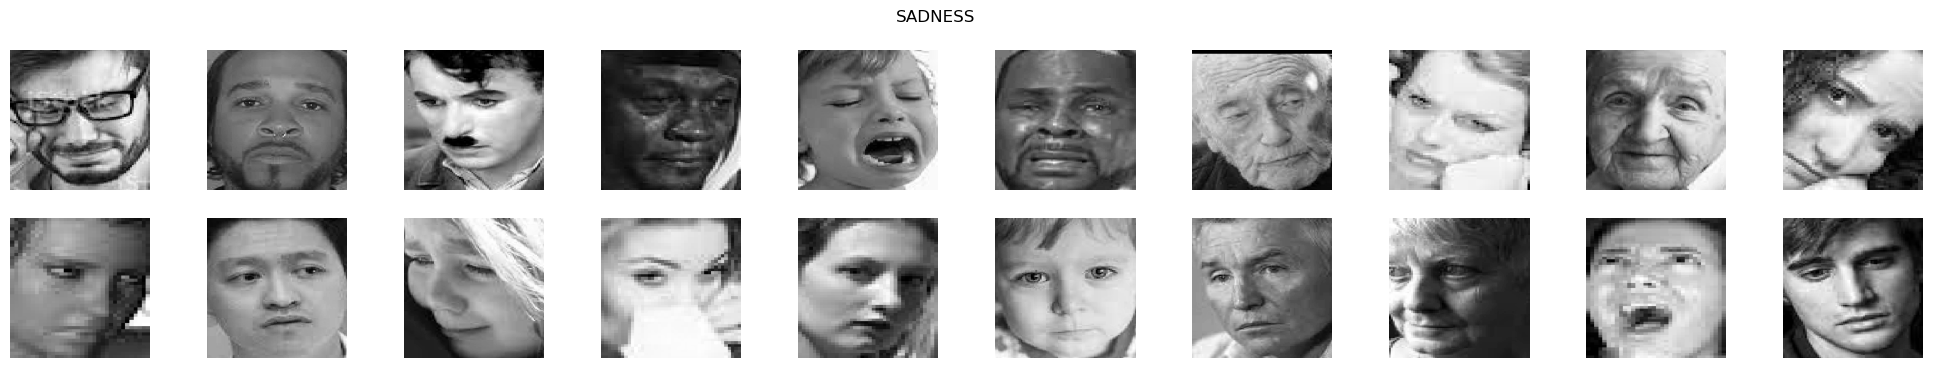

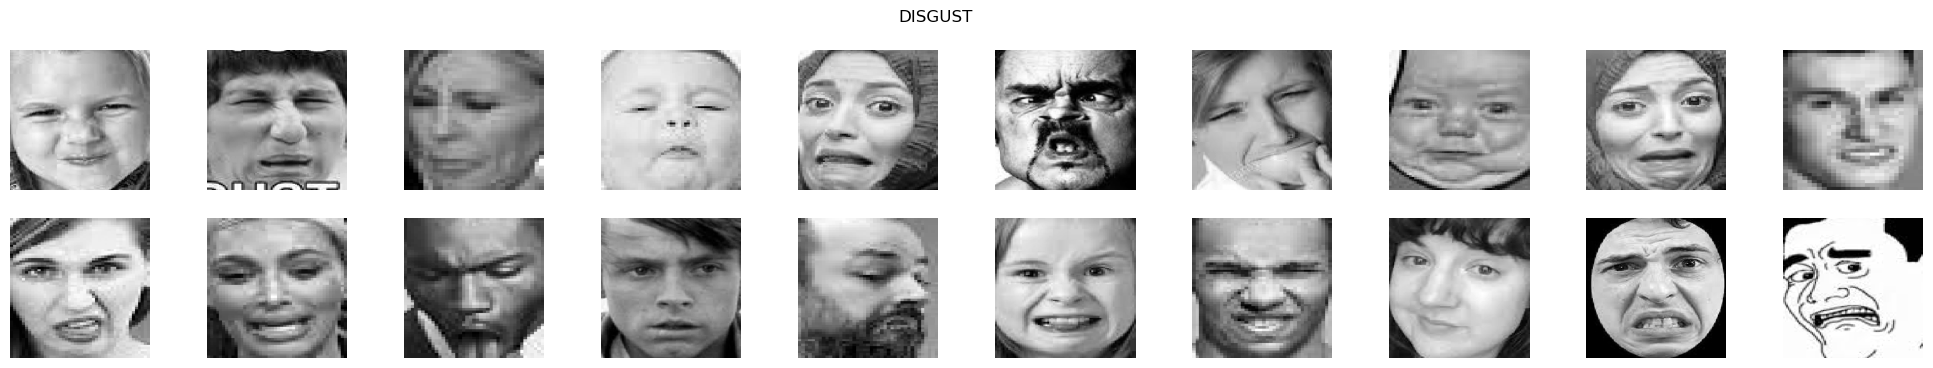

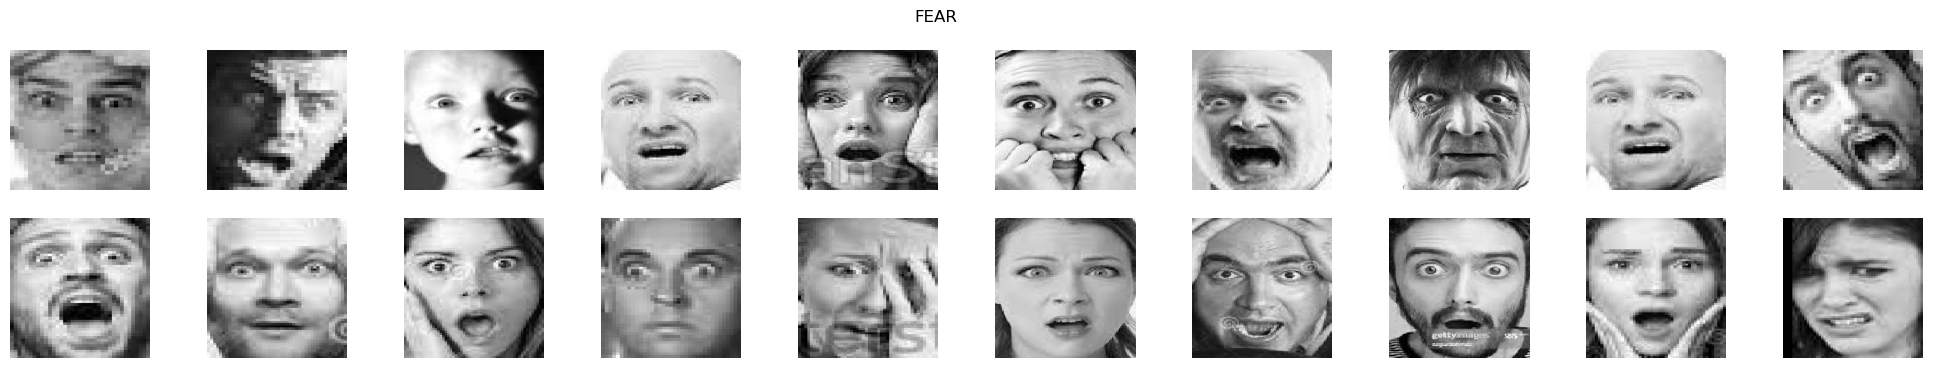

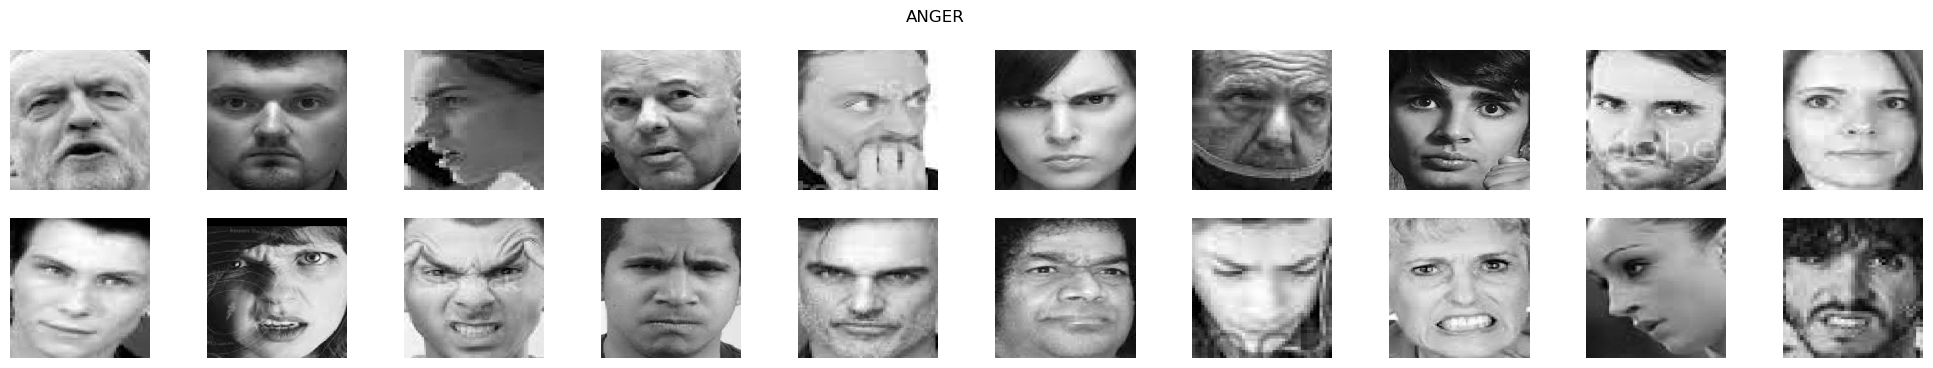

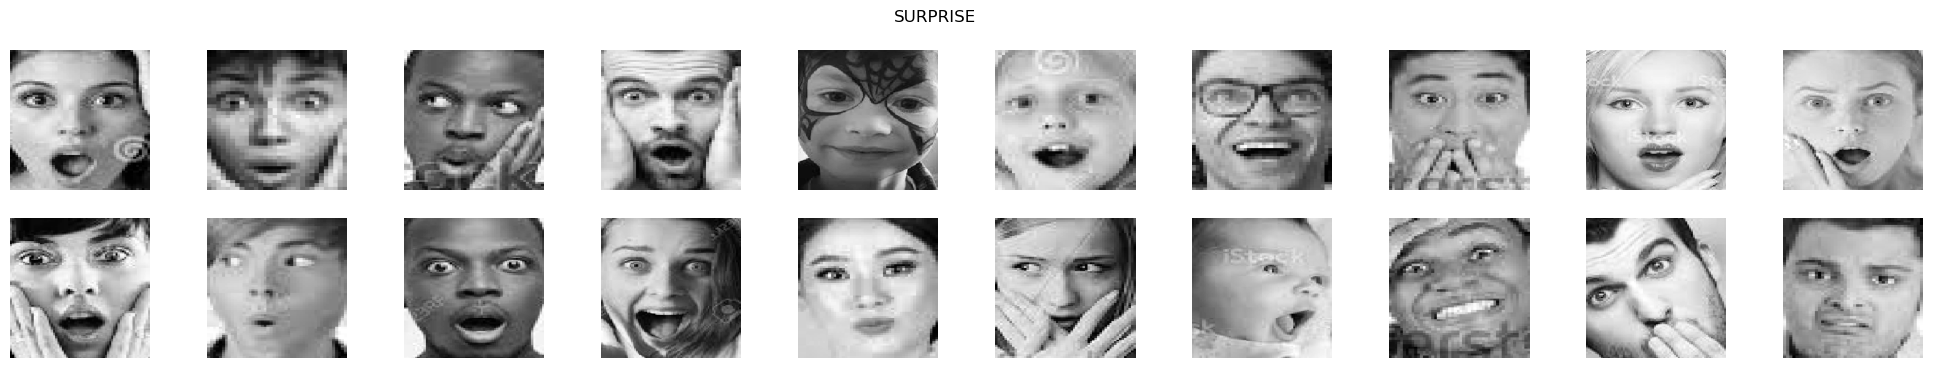

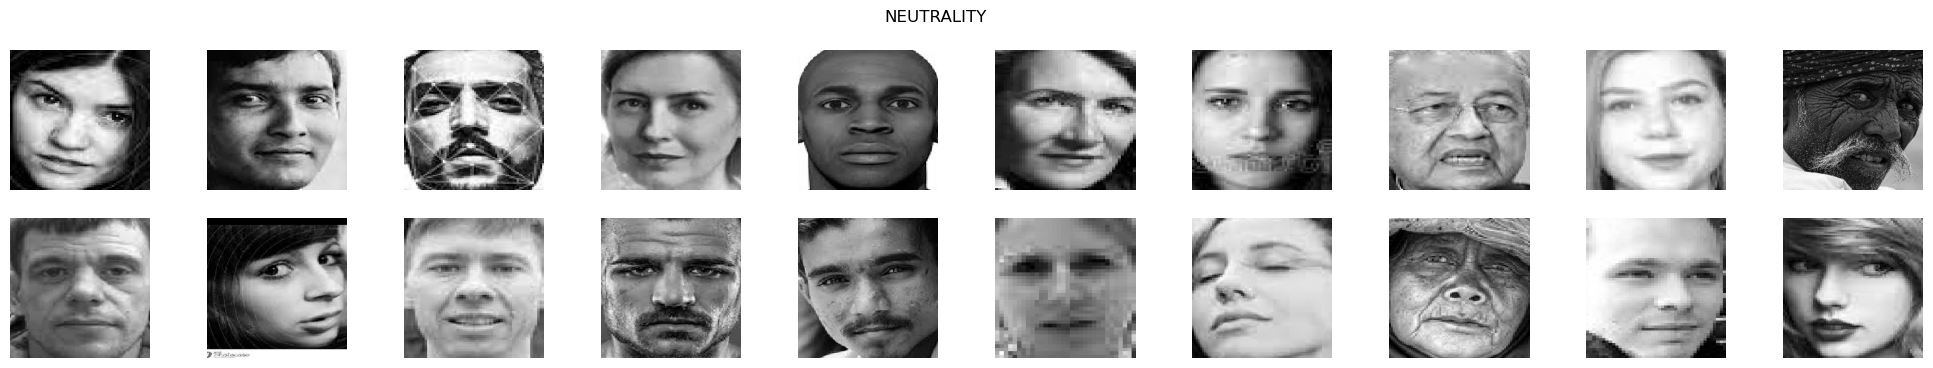

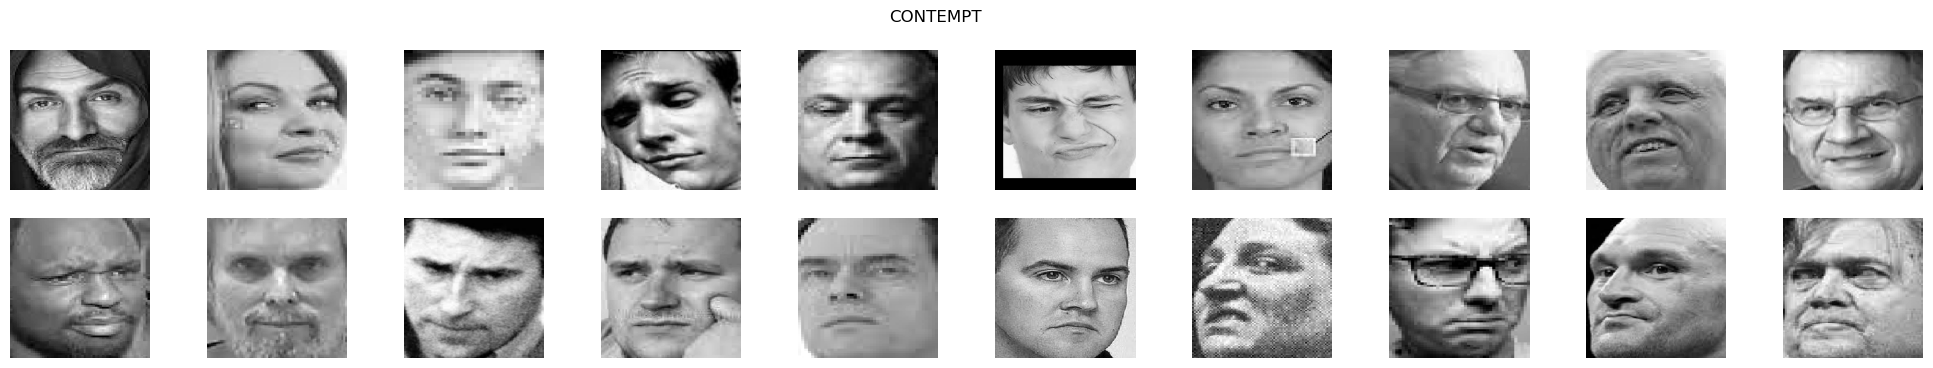

In [5]:
for label in Images:
    images = Images[label]
    class_name = class_names[label]
    f, axs = plt.subplots(2, 10, figsize=(25, 4))
    axs = axs.reshape(-1)
    f.suptitle(class_name.upper())
    for i, image in enumerate(images):
        ax = plt.subplot(2, 10, i + 1)
        axs[i].imshow(image.numpy().astype("uint8"), cmap='gray')
        #axs[i].suptitle(class_names[label], y=-0.20)
        axs[i].axis("off")    

In [6]:
validation_dataset_cardinality = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(validation_dataset_cardinality // 5)

print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 35
Number of test batches: 7


In [7]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

# Use data augmentation
data_augmentation = tf.keras.Sequential(
    [
          tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal")
        , tf.keras.layers.experimental.preprocessing.RandomRotation(factor=0.05)
        , tf.keras.layers.experimental.preprocessing.RandomZoom(height_factor=0.1, width_factor=0.1)
    ]
)

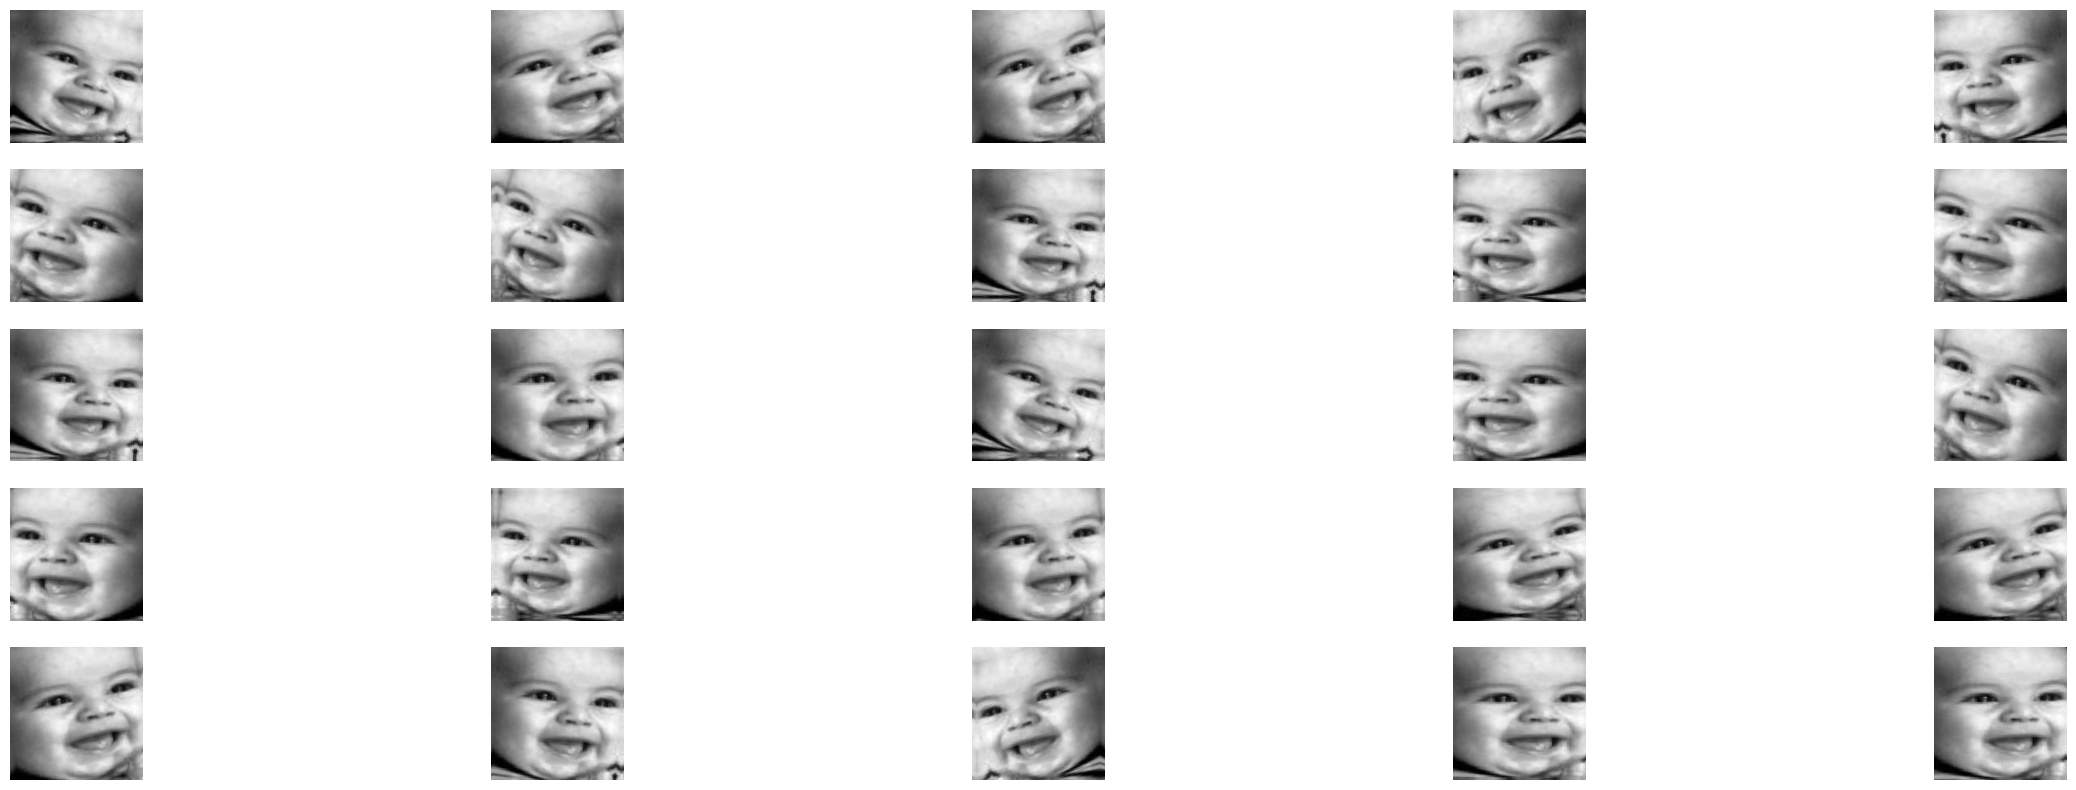

In [8]:
for images, labels in train_dataset.take(1):
    plt.figure(figsize=(30, 10))
    image = images[0]    
    for i in range(25):
        ax = plt.subplot(5, 5, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(image, 0))
        plt.imshow(augmented_image[0].numpy() / 255, cmap='gray')
        plt.axis('off')
plt.show()

In [9]:
# MODEL
INPUT_SHAPE = image.shape
#print('INPUT SHAPE: ',  INPUT_SHAPE)
base_model = tf.keras.Sequential()

base_model.add(layers.Input(shape=INPUT_SHAPE))

base_model.add(layers.Conv2D(filters=30, kernel_size=3, padding='same', kernel_regularizer=regularizers.L2(1e-4), bias_regularizer=regularizers.L2(1e-4), name='CONV01'))
base_model.add(layers.BatchNormalization(name='BNOR01'))
base_model.add(layers.Activation('relu', name='RELU01'))
base_model.add(layers.Dropout(0.2, name='DROP01'))

base_model.add(layers.MaxPool2D(pool_size=(2,2), name='MP0102'))

base_model.add(layers.Conv2D(filters=60, kernel_size=3, padding='same', kernel_regularizer=regularizers.L2(1e-4), bias_regularizer=regularizers.L2(1e-4), name='CONV02'))
base_model.add(layers.BatchNormalization(name='BNOR02'))
base_model.add(layers.Activation('relu', name='RELU02'))
base_model.add(layers.Dropout(0.2, name='DROP02'))

base_model.add(layers.MaxPool2D(pool_size=(2,2), name='MP0203'))

base_model.add(layers.Conv2D(filters=120, kernel_size=3, padding='same', kernel_regularizer=regularizers.L2(1e-4), bias_regularizer=regularizers.L2(1e-4), name='CONV03'))
base_model.add(layers.BatchNormalization(name='BNOR03'))
base_model.add(layers.Activation('relu', name='RELU03'))
base_model.add(layers.Dropout(0.2, name='DROP03'))

base_model.add(layers.MaxPool2D(pool_size=(2,2), name='MP0304'))

base_model.add(layers.Conv2D(filters=240, kernel_size=3, padding='same', kernel_regularizer=regularizers.L2(1e-4), bias_regularizer=regularizers.L2(1e-4), name='CONV04'))
base_model.add(layers.BatchNormalization(name='BNOR04'))
base_model.add(layers.Activation('relu', name='RELU04'))
base_model.add(layers.Dropout(0.2, name='DROP04'))

base_model.add(layers.Flatten(name='FLAT01'))

base_model.add(layers.Dense(64, kernel_regularizer=regularizers.L2(1e-4), bias_regularizer=regularizers.L2(1e-4), name='DENS01'))
base_model.add(layers.BatchNormalization(name='BNOR05'))
base_model.add(layers.Activation('relu', name='RELU05'))
base_model.add(layers.Dropout(0.2, name='DROP05'))

base_model.add(layers.Dense(8, kernel_regularizer=regularizers.L2(1e-4), bias_regularizer=regularizers.L2(1e-4),  name='DENS02'))
base_model.add(layers.Activation('softmax', name='SOFT01'))

base_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 CONV01 (Conv2D)             (None, 224, 224, 30)      300       
                                                                 
 BNOR01 (BatchNormalization)  (None, 224, 224, 30)     120       
                                                                 
 RELU01 (Activation)         (None, 224, 224, 30)      0         
                                                                 
 DROP01 (Dropout)            (None, 224, 224, 30)      0         
                                                                 
 MP0102 (MaxPooling2D)       (None, 112, 112, 30)      0         
                                                                 
 CONV02 (Conv2D)             (None, 112, 112, 60)      16260     
                                                                 
 BNOR02 (BatchNormalization)  (None, 112, 112, 60)    

In [10]:
inputs = layers.Input(shape=INPUT_SHAPE)
x = data_augmentation(inputs)
outputs = base_model(x)
model = tf.keras.Model(inputs, outputs)

In [11]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 1)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 1)       0         
                                                                 
 sequential_1 (Sequential)   (None, 8)                 12385800  
                                                                 
Total params: 12,385,800
Trainable params: 12,384,772
Non-trainable params: 1,028
_________________________________________________________________


In [12]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = model(image_batch)
print(feature_batch.shape)

2022-11-02 20:13:45.404787: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8401
2022-11-02 20:13:45.943550: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


(16, 8)


In [13]:
print('CNN output format')
print(' '.join('{:^12s}'.format(el) for el in class_names))
for row in feature_batch.numpy():
   print(' '.join('{:^12.2f}'.format(el) for el in row))

CNN output format
   anger       contempt     disgust        fear      happiness    neutrality    sadness      surprise  
    0.00         0.00         0.00         0.00         0.34         0.00         0.00         0.66    
    0.00         0.00         0.01         0.00         0.90         0.00         0.00         0.09    
    0.00         0.00         0.00         0.00         1.00         0.00         0.00         0.00    
    0.00         0.00         0.00         0.00         0.92         0.06         0.01         0.00    
    0.00         0.00         0.00         0.00         1.00         0.00         0.00         0.00    
    0.00         0.34         0.00         0.00         0.64         0.00         0.00         0.02    
    0.00         0.00         0.01         0.00         0.99         0.00         0.00         0.00    
    0.00         0.00         0.00         0.00         0.99         0.00         0.00         0.01    
    0.01         0.00         0.02         0.0

In [14]:
print('Dataset label format')
label_batch.numpy()

Dataset label format


array([1, 0, 4, 2, 5, 4, 6, 1, 3, 4, 6, 6, 0, 4, 6, 4], dtype=int32)

In [15]:
METRICS = [
      tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')
]

In [16]:
# Compile the model
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=METRICS)

In [17]:
# Train the model
loss0, accuracy0 = model.evaluate(validation_dataset)
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

35/35 [==============================] - 3s 77ms/step - loss: 7.0208 - accuracy: 0.2609
initial loss: 7.02
initial accuracy: 0.26


In [18]:
initial_epochs = 50
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/50
309/309 [==============================] - 96s 296ms/step - loss: 2.0250 - accuracy: 0.3051 - val_loss: 1.8074 - val_accuracy: 0.3942
Epoch 2/50
309/309 [==============================] - 91s 295ms/step - loss: 1.7646 - accuracy: 0.3783 - val_loss: 1.7919 - val_accuracy: 0.3777
Epoch 3/50
309/309 [==============================] - 93s 301ms/step - loss: 1.6617 - accuracy: 0.4152 - val_loss: 1.6797 - val_accuracy: 0.4325
Epoch 4/50
309/309 [==============================] - 90s 291ms/step - loss: 1.5802 - accuracy: 0.4409 - val_loss: 1.5889 - val_accuracy: 0.4507
Epoch 5/50
309/309 [==============================] - 93s 300ms/step - loss: 1.5108 - accuracy: 0.4693 - val_loss: 1.5388 - val_accuracy: 0.4507
Epoch 6/50
309/309 [==============================] - 94s 305ms/step - loss: 1.4593 - accuracy: 0.4956 - val_loss: 1.5636 - val_accuracy: 0.4544
Epoch 7/50
309/309 [==============================] - 89s 287ms/step - loss: 1.4166 - accuracy: 0.4987 - val_loss: 1.7291 - val_ac

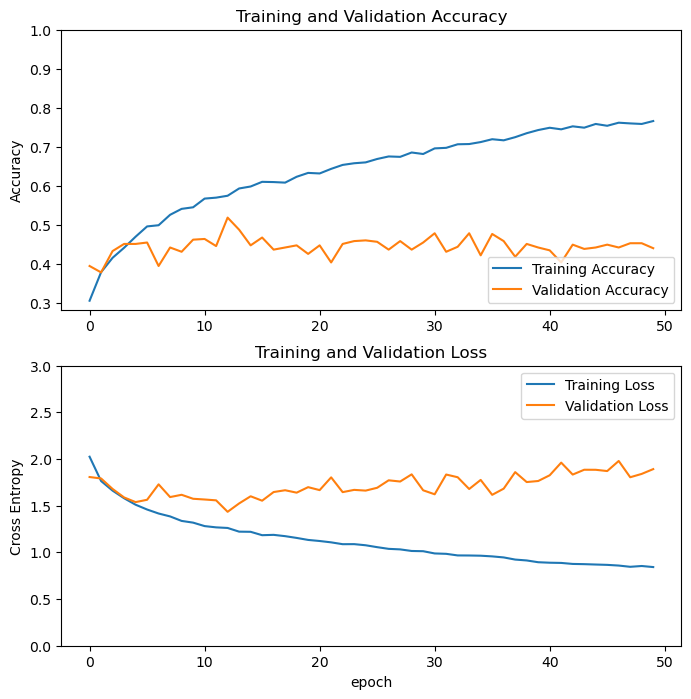

In [19]:
# Show the learning curves of the training and validation accuracy/loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()), 1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0, 3.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [20]:
Labels = []
Predss = []
count = 0
for batch, labels in validation_dataset:
    logits = model.predict_on_batch(batch)
    preds  = np.argmax(logits, axis=1) 
    Predss += preds.tolist()
    Labels += labels.numpy().tolist()
    count  += 1

In [21]:
print('Confusion matrix')
confusion = confusion_matrix(Labels, Predss)
print(' '.join('{:<12s}'.format(el) for el in class_names))
for row in confusion:
    print(' '.join('{:<12d}'.format(el) for el in row))
print('===')
print('Precision per class')
num = [confusion[i,i] for i in range(len(confusion))]
den = np.sum(confusion, axis=0)
print(' '.join('{:<12s}'.format(el) for el in class_names))
print(' '.join('{:<12.2f}'.format(el) for el in num/den))
print('---')
print('mean precision: {:<12.2f}'.format(np.mean(num/den)))
print('===')
print('Recall per class')
num = [confusion[i,i] for i in range(len(confusion))]
den = np.sum(confusion, axis=1)
print(' '.join('{:<12s}'.format(el) for el in class_names))
print(' '.join('{:<12.2f}'.format(el) for el in num/den))
print('---')
print('mean recall (balanced accuracy score): {:<12.2f}'.format(np.mean(num/den)))

Confusion matrix
anger        contempt     disgust      fear         happiness    neutrality   sadness      surprise    
11           0            0            0            25           21           23           2           
1            1            0            0            2            7            3            0           
4            1            3            0            17           7            16           1           
1            0            0            5            6            11           16           13          
2            0            0            0            121          16           7            2           
1            0            0            1            4            29           18           0           
0            1            0            0            10           29           39           0           
0            0            0            1            21           7            10           32          
===
Precision per class
anger        contempt  

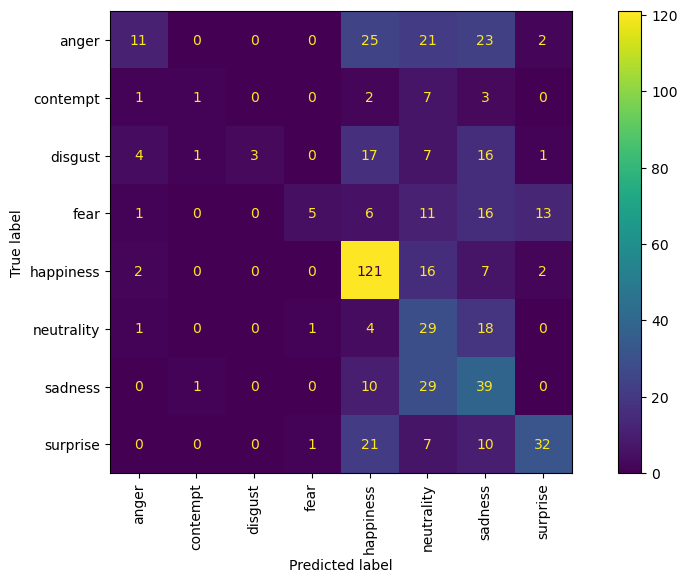

In [22]:
fig, ax = plt.subplots(figsize=(20*0.6, 10*0.6))
ConfusionMatrixDisplay.from_predictions(Labels, Predss, normalize=None, display_labels=class_names, xticks_rotation='vertical', values_format='d', ax=ax)

7/7 [==============================] - 0s 62ms/step - loss: 1.9851 - accuracy: 0.4107
Test accuracy : 0.4107142984867096
pred [[5.84429735e-03 1.82972215e-02 2.26063319e-02 2.62647111e-04
  8.08164597e-01 1.34673119e-01 9.60122887e-03 5.50461060e-04]
 [3.51638347e-01 1.31022990e-01 9.07154679e-02 4.81394939e-02
  2.75951773e-01 4.19227742e-02 3.85436155e-02 2.20655389e-02]
 [3.78733152e-04 5.20030560e-04 3.62611972e-05 6.00913132e-04
  9.49221671e-01 2.22508423e-02 2.48732828e-02 2.11814512e-03]
 [9.89231979e-04 4.65774559e-04 1.56301146e-04 1.49155175e-02
  5.71036875e-01 3.90249230e-02 1.15509704e-02 3.61860394e-01]
 [3.09185032e-03 5.78545325e-04 1.58690527e-04 5.24123684e-02
  1.52859278e-02 4.82291073e-01 2.39604637e-01 2.06576943e-01]
 [7.52122665e-04 1.69605331e-03 7.97018947e-05 5.68226464e-02
  8.48766491e-02 7.94023741e-03 9.57415206e-04 8.46875131e-01]
 [5.66955241e-05 2.83144473e-04 1.56404894e-05 6.27215579e-03
  6.70959204e-02 4.37245471e-03 1.69055231e-04 9.21734929e-01]

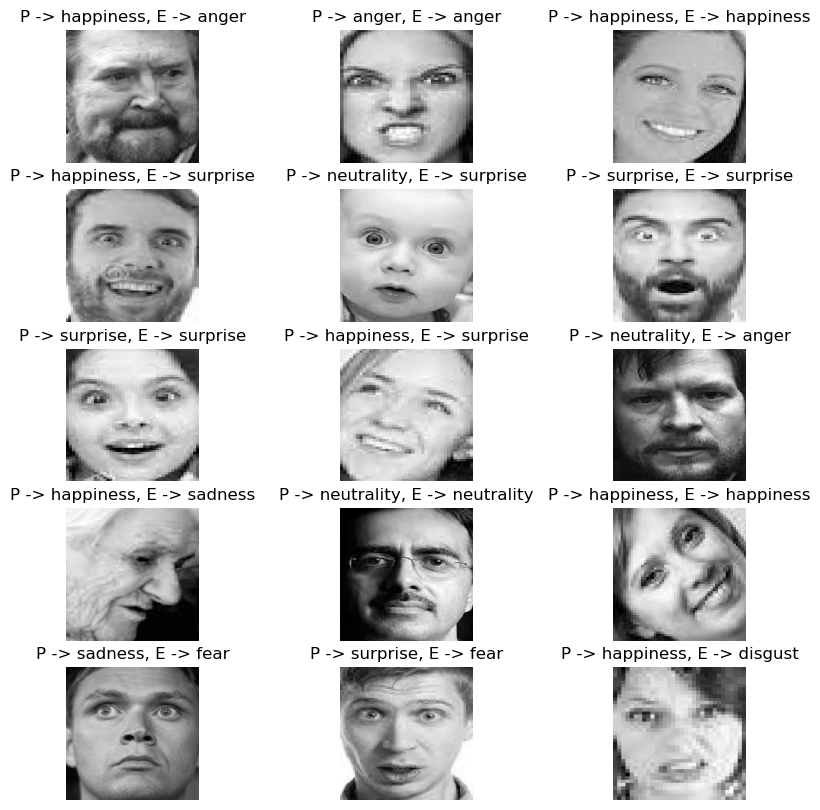

In [23]:
# Evaluation and prediction
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

#Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)
print('pred', predictions)


# Apply a sigmoid since our model returns logits
predicted_class = np.argmax(predictions, axis=-1)

print('Predictions:\n', predicted_class)
print('Labels:\n', label_batch)
print('Classes:\n', class_names)
plt.figure(figsize=(10, 10))
for i in range(15):
    ax = plt.subplot(5, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"), cmap='gray')
    plt.title('P -> {}, E -> {}'.format(class_names[predicted_class[i]], class_names[label_batch[i]]))
    plt.axis("off")